In [ ]:
import cupy as cp
import numpy as np
import pandas as pd
from types import SimpleNamespace

from utils import *
from rec import Rec

# Init data sizes and parametes of the PXM of ID16A

In [ ]:
n = 128  # object size in each dimension
ntheta = 128  # number of angles (rotations)
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

ndist = 4 # number of distances from the focal spot in holotomography
detector_pixelsize = 3e-6 # detector pixel size
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208  # focus to detector distance [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3, 1.7065e-3, 2.3975e-3, 3.8320e-3])[:ndist]-sx0 # distances
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance # adjusted distances
magnifications = focusToDetectorDistance/z1 # magnifications
voxelsize = detector_pixelsize/magnifications[0]*2048/n/2  # object voxel size

norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = distances*norm_magnifications**2 # readjusted distances
z1p = z1[0]  # positions of the probe for reconstruction

z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnificationsp = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distancesp = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnificationsp/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distancesp = distancesp*norm_magnifications2**2
distancesp = distancesp*(z1p/z1)**2

npsi = int(np.ceil(n/norm_magnifications[-1]/8))*8  # reconstructed object size based on magnification and detector size


In [ ]:
args = SimpleNamespace()
args.n = n
args.ndist = ndist
args.ntheta = ntheta
args.npsi = npsi

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distances
args.distancep = distancesp
args.rotation_axis = args.npsi/2

args.theta = theta
args.norm_magnifications = norm_magnifications
# create class
cl_rec = Rec(args)

## Read data

In [ ]:
data = cp.load('data.npy')
ref = cp.load('ref.npy')
r = cp.load('shifts.npy')
# for k in range(ndist):
mshow_complex(data[0,0]+1j*data[0,-1],True)

# Back propagate probe for the intial guess

In [ ]:
q_init = cp.ones([1,args.n,args.n],dtype='complex64')
q_init = cl_rec.DpT(cl_rec.DT(cp.sqrt(ref).astype('complex64'),0),0)
mshow_polar(q_init[0],True)


# Reconstruct

852) err=nan


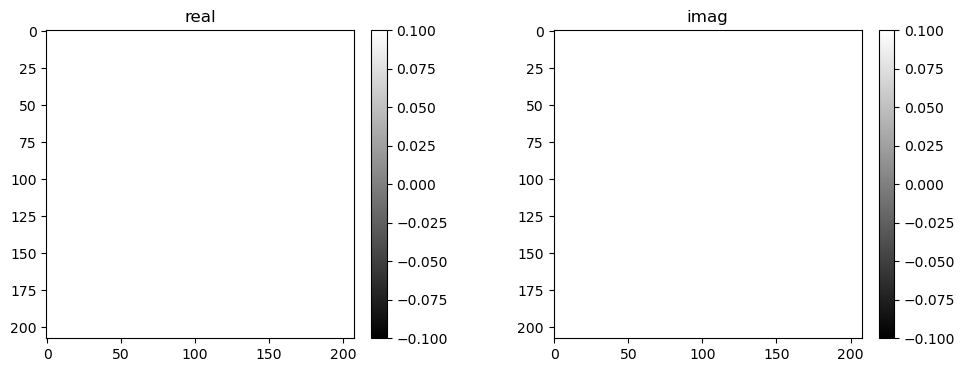

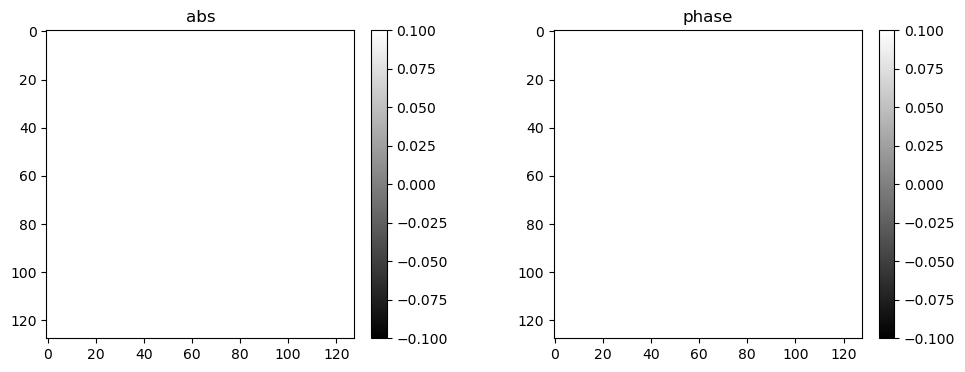

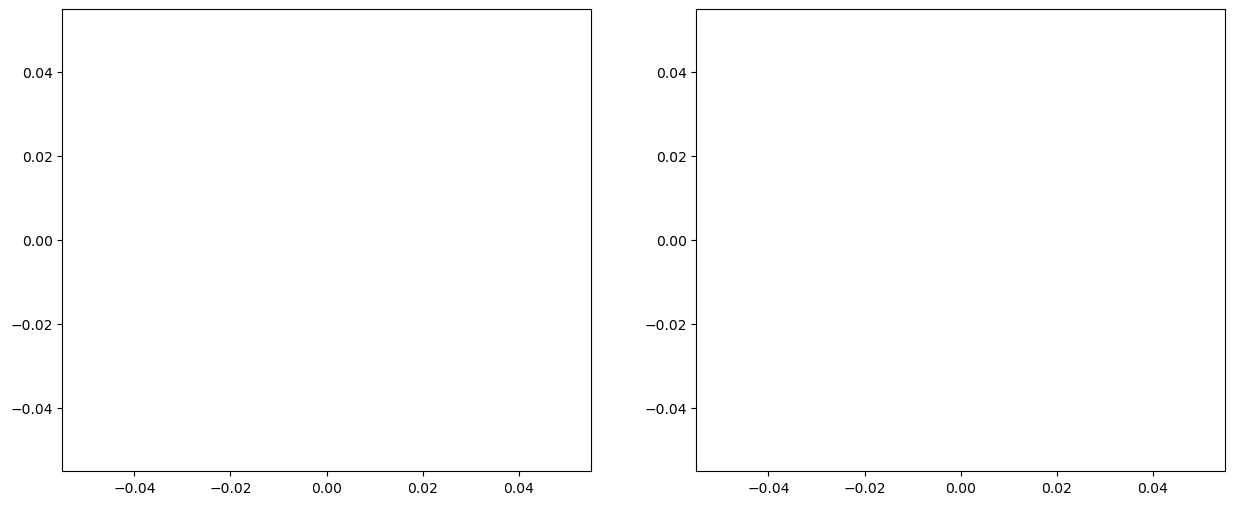

In [ ]:
args.niter=2049 # number of iters
args.vis_step=4 # show visualization step
args.err_step=4# show error step
args.path_out='/local/data/out00' # output forlder for dumped results for each vis step
args.show=True # show visualization or not
args.rho=[1,25,15] # scaling of variables to control the convergence

# create solver class
cl_rec = Rec(args)

# variables initiated with a guess
vars={}
vars["u"] = cp.zeros([npsi,npsi,npsi],dtype='complex64')
vars["q"] = q_init
vars["r"] = r
vars["r_init"] = r.copy()
vars["psi"] = cl_rec.R(vars['u'])        
vars["psi"][:] = cl_rec.expR(vars["psi"])        
vars["table"] = pd.DataFrame(columns=["iter", "err", "time"])  #monitor convregence

vars = cl_rec.BH(cp.sqrt(data), vars)  

In [ ]:
1.15527e+04, 4) err=8.84536e+03

In [ ]:
plt.title('Convergence')
plt.plot(vars["table"]['err'])
plt.grid()
plt.xlabel('iter')
plt.yscale('log')